# _Set Up: Trial 21_

__July 4, 2019__

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# fastai libraries
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
from fastai.callbacks import EarlyStoppingCallback

In [3]:
# import libraries
import pandas as pd
pd.options.display.max_columns = None
import numpy as np
import random
import os
from pathlib import Path

# Matplotlib
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [4]:
path = Config.data_path()
path

PosixPath('/home/jupyter/springboard-capstone-2/data')

# _Load in Data_

In [5]:
from test_folder import replicate

sample_df = replicate.load_data(path, 1, percent=0.13);

Added valid column
------------------------------
Extracted Patient ID from Path column and created new column named Patient_id
------------------------------
Concatenated train_df and valid_df, resulting shape = (223648, 21)
------------------------------
Created function named seed_data to set seed for sample data
------------------------------
Seeded data.
------------------------------
Created sample dataframe with input seed and 13.0% of original data
Resulting sample df has shape of (29285, 21)
------------------------------


In [6]:
sample_df.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,valid,Patient_id
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,False,patient00003
11,CheXpert-v1.0-small/train/patient00006/study1/...,Female,42,Frontal,AP,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,False,patient00006
44,CheXpert-v1.0-small/train/patient00015/study1/...,Female,76,Frontal,AP,NaN,NaN,NaN,1.0,NaN,1.0,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,False,patient00015
45,CheXpert-v1.0-small/train/patient00015/study2/...,Female,76,Frontal,AP,NaN,NaN,NaN,-1.0,NaN,1.0,-1.0,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,False,patient00015
91,CheXpert-v1.0-small/train/patient00027/study1/...,Male,56,Frontal,PA,NaN,0.0,NaN,1.0,NaN,NaN,0.0,NaN,1.0,0.0,0.0,NaN,NaN,NaN,False,patient00027


In [7]:
sample_df = replicate.dl_dataframe_setup(sample_df, 'Cardiomegaly');

Created data set with expressed competition pathology, replacing NaN's with 0 and resetting the index
------------------------------

Cardiomegaly
------------------------------
Shape of sample_df: (29285, 3)


In [8]:
sample_df.head()

,Path,valid,Cardiomegaly
0,CheXpert-v1.0-small/train/patient00003/study1/...,False,0.0
1,CheXpert-v1.0-small/train/patient00006/study1/...,False,0.0
2,CheXpert-v1.0-small/train/patient00015/study1/...,False,0.0
3,CheXpert-v1.0-small/train/patient00015/study2/...,False,0.0
4,CheXpert-v1.0-small/train/patient00027/study1/...,False,0.0


In [9]:
sample_df['Cardiomegaly'].value_counts()

 0.0    24787
 1.0     3409
-1.0     1089
Name: Cardiomegaly, dtype: int64

In [10]:
# drop uncertain observations
sample_df = replicate.uignore(sample_df, 'Cardiomegaly');

Dropped -1 observations.
------------------------------
Converted pathology column into integer type.
------------------------------
Shape of new dataframe: (28196, 3)


In [11]:
sample_df['Cardiomegaly'].value_counts()

0    24787
1     3409
Name: Cardiomegaly, dtype: int64

In [12]:
print('The percentage of the data we dropped: {}%'.format(1089 / (24787 + 3409 + 1089) * 100))

The percentage of the data we dropped: 3.718627283592283%


# _Set Up for Deep Learning_

In [13]:
src = replicate.get_src(sample_df, path, 'Cardiomegaly');

In [14]:
# set image size to 320
data = replicate.get_data(320, src)

using bs=16, have 7601MB of GPU RAM free.
------------------------------
Data ready.


In [15]:
data

ImageDataBunch;

Train: LabelList (27962 items)
x: ImageList
Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320)
y: CategoryList
0,0,0,0,0
Path: /home/jupyter/springboard-capstone-2/data;

Valid: LabelList (234 items)
x: ImageList
Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320)
y: CategoryList
1,0,0,0,0
Path: /home/jupyter/springboard-capstone-2/data;

Test: None

# _Set Up DL Model_

In [16]:
# create a pretrained densenet121 cnn_learner with error rate and AUROC as the metrics with a ps of 0.5 (i.e. 50% of randomly selected neurons will be ignored from the n-1 layer) and batch normalization
learn = cnn_learner(data=data, base_arch=models.densenet121, 
                    metrics=[error_rate, AUROC(), Precision(), Recall()], pretrained=True,
                    ps=0.5, bn_final=True)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.94E+00
Min loss divided by 10: 2.00E+00


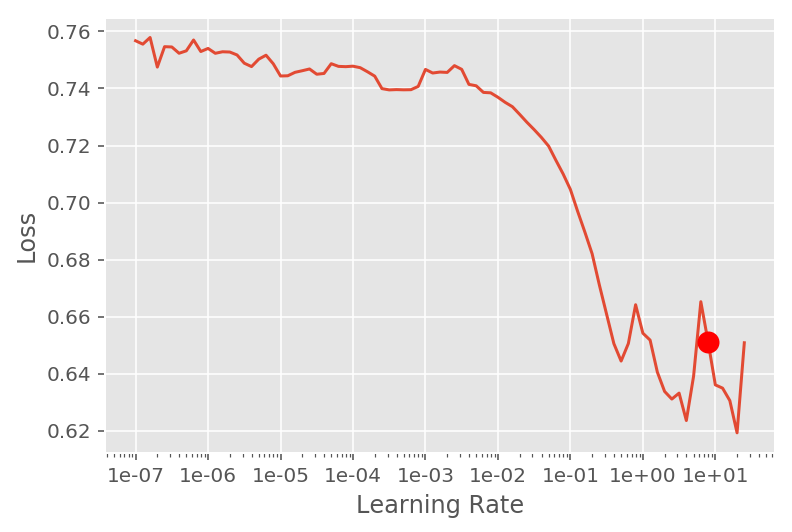

In [17]:
from test_folder import deeplearning

deeplearning.lr_finder_plot(learn)

In [18]:
# set learning rate
lr = 0.2

In [19]:
# check the loss function
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

# _First Round of Training_

In [20]:
learn.fit_one_cycle(3, lr, callbacks=[EarlyStoppingCallback(learn, monitor='auroc', min_delta=0.01, patience=2)])

epoch,train_loss,valid_loss,error_rate,auroc,precision,recall,time
0,0.377107,23.612673,0.307692,0.460135,0.166667,0.014706,10:09
1,0.390844,0.654632,0.290598,0.712527,nan,0.000000,10:01
2,0.316983,0.678712,0.290598,0.748583,nan,0.000000,10:00


In [23]:
learn.metrics = [error_rate, AUROC()]
learn.metrics

[<function fastai.metrics.error_rate(input: torch.Tensor, targs: torch.Tensor) -> <function NewType.<locals>.new_type at 0x7fb65fe32268>>,
 AUROC()]

In [24]:
learn.save('trial21-rd1')

# _Second Round of Training_

In [25]:
learn.load('trial21-rd1');

In [26]:
learn.fit_one_cycle(3, lr, callbacks=[EarlyStoppingCallback(learn, monitor='auroc', min_delta=0.01, patience=2)])

epoch,train_loss,valid_loss,error_rate,auroc,time
0,0.375435,3.977142,0.482906,0.511650,10:00
1,0.339444,0.895957,0.299145,0.687190,10:00
2,0.332724,0.697313,0.290598,0.758948,10:00


In [27]:
learn.save('trial21-rd2');

# _Third Round of Training_

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.16E-07
Min loss divided by 10: 1.00E-04


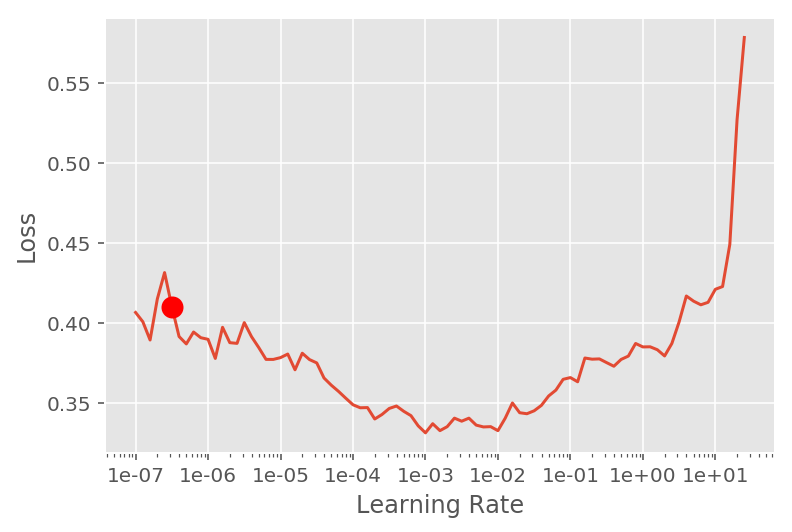

In [31]:
from test_folder import deeplearning

learn.unfreeze()
deeplearning.lr_finder_plot(learn)

In [32]:
learn.load('trial21-rd2');

In [33]:
# slice training, with slower lr for lower layers and higher lr for higher layers
learn.fit_one_cycle(3, callbacks=[EarlyStoppingCallback(learn, monitor='auroc', min_delta=0.01, patience=2)])

epoch,train_loss,valid_loss,error_rate,auroc,time
0,0.344320,0.595331,0.273504,0.756290,13:26
1,0.317696,0.705195,0.286325,0.733788,13:27
2,0.288750,0.643171,0.277778,0.780120,13:27


In [34]:
learn.save('trial21-rd3')

# _New Sample Data Set_

In [35]:
# new sample df
sample_df2 = replicate.load_data(path, 25, percent=0.13);

Added valid column
------------------------------
Extracted Patient ID from Path column and created new column named Patient_id
------------------------------
Concatenated train_df and valid_df, resulting shape = (223648, 21)
------------------------------
Created function named seed_data to set seed for sample data
------------------------------
Seeded data.
------------------------------
Created sample dataframe with input seed and 13.0% of original data
Resulting sample df has shape of (29113, 21)
------------------------------


In [36]:
sample_df2 = replicate.dl_dataframe_setup(sample_df2, 'Cardiomegaly');

Created data set with expressed competition pathology, replacing NaN's with 0 and resetting the index
------------------------------

Cardiomegaly
------------------------------
Shape of sample_df: (29113, 3)


In [37]:
# drop uncertain observations
sample_df2 = replicate.uignore(sample_df2, 'Cardiomegaly');

Dropped -1 observations.
------------------------------
Converted pathology column into integer type.
------------------------------
Shape of new dataframe: (28042, 3)


In [38]:
src2 = replicate.get_src(sample_df2, path, 'Cardiomegaly');

In [39]:
# set image size to 320
data2 = replicate.get_data(320, src2)

using bs=16, have 6948MB of GPU RAM free.
------------------------------
Data ready.


In [40]:
data2

ImageDataBunch;

Train: LabelList (27808 items)
x: ImageList
Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320)
y: CategoryList
0,0,0,0,0
Path: /home/jupyter/springboard-capstone-2/data;

Valid: LabelList (234 items)
x: ImageList
Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320)
y: CategoryList
1,0,0,0,0
Path: /home/jupyter/springboard-capstone-2/data;

Test: None

In [41]:
# assign new data set to data being used by learner
learn.data = data2

# _Fourth Round of Training_

In [42]:
learn.load('trial21-rd3');

In [43]:
# slice training, with slower lr for lower layers and higher lr for higher layers
learn.fit_one_cycle(3, callbacks=[EarlyStoppingCallback(learn, monitor='auroc', min_delta=0.01, patience=2)])

epoch,train_loss,valid_loss,error_rate,auroc,time
0,0.327291,0.645733,0.286325,0.775780,13:33
1,0.319379,0.657440,0.277778,0.767629,13:23
2,0.328718,0.657985,0.277778,0.786676,13:23


In [44]:
learn.save('trial21-rd4')

# _Interpretation from Training So Far_

In [45]:
interp = ClassificationInterpretation.from_learner(learn)

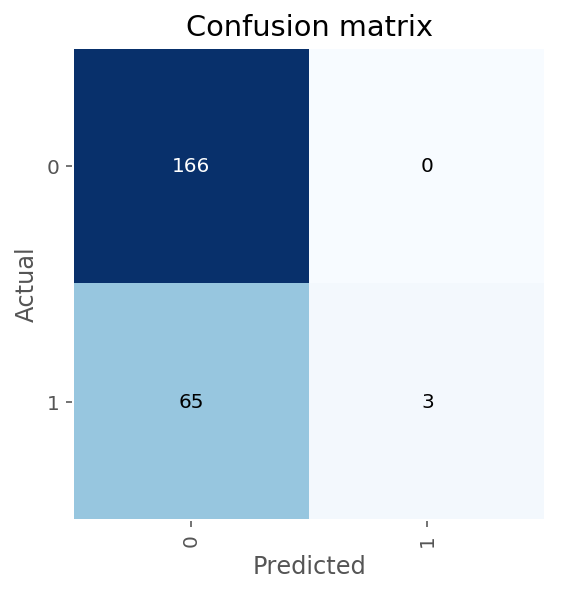

In [46]:
interp.plot_confusion_matrix()